In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('Ford Motor Stock Price History.csv')

# Clean data
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

def convert_volume(vol_str):
    if isinstance(vol_str, str):
        if 'M' in vol_str:
            return float(vol_str.replace('M', '')) * 1_000_000
        elif 'K' in vol_str:
            return float(vol_str.replace('K', '')) * 1_000
    return float(vol_str)

df['Volume'] = df['Vol.'].apply(convert_volume)
df['Change_pct'] = df['Change %'].str.replace('%', '').astype(float)
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df_cleaned = df.drop(columns=['Vol.', 'Change %'])

C:\Users\Ahmad\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


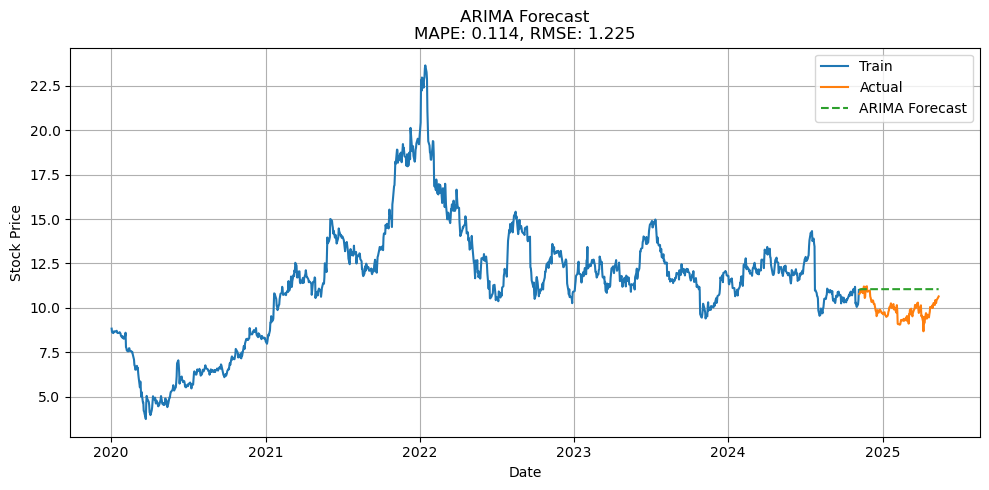

In [8]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from math import sqrt

# Prepare time series
ts = df_cleaned[['Date', 'Price']].set_index('Date')
ts = ts.asfreq('B')
ts['Price'] = ts['Price'].interpolate()

# Split
train_arima = ts.iloc[:-135]
test_arima = ts.iloc[-135:]

# Train ARIMA model
model_arima = ARIMA(train_arima, order=(5, 1, 0))
model_fit = model_arima.fit()
forecast_arima = model_fit.forecast(steps=135)

# Metrics
mape_arima = mean_absolute_percentage_error(test_arima, forecast_arima)
rmse_arima = sqrt(mean_squared_error(test_arima, forecast_arima))

# Plot ARIMA
plt.figure(figsize=(10, 5))
plt.plot(train_arima.index, train_arima['Price'], label='Train')
plt.plot(test_arima.index, test_arima['Price'], label='Actual')
plt.plot(test_arima.index, forecast_arima, label='ARIMA Forecast', linestyle='--')
plt.title(f'ARIMA Forecast\nMAPE: {mape_arima:.3f}, RMSE: {rmse_arima:.3f}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

01:17:31 - cmdstanpy - INFO - Chain [1] start processing
01:17:32 - cmdstanpy - INFO - Chain [1] done processing


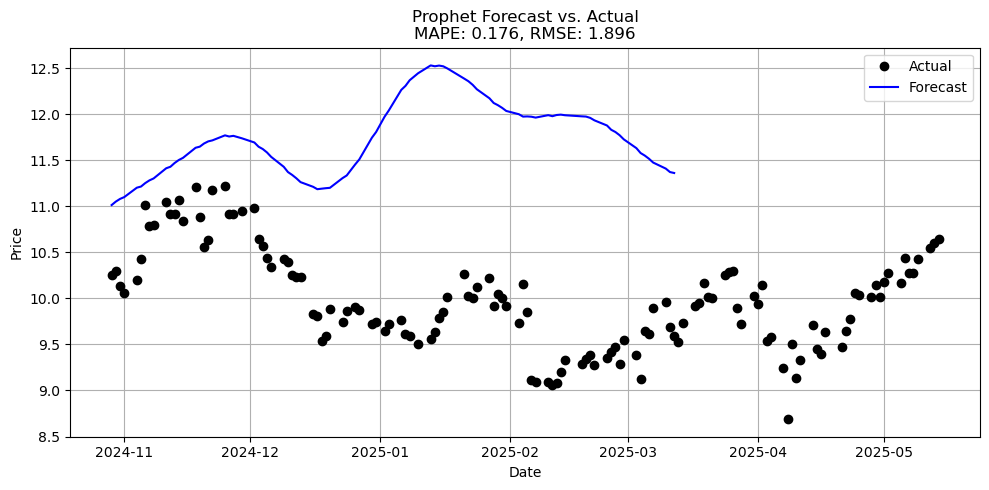

In [9]:
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from math import sqrt

# Step 1: Prepare data
df_prophet = df_cleaned[['Date', 'Price']].rename(columns={'Date': 'ds', 'Price': 'y'})
df_prophet.dropna(subset=['ds', 'y'], inplace=True)  # Remove rows with NaNs

# Step 2: Train/test split
train_prophet = df_prophet.iloc[:-135]
test_prophet = df_prophet.iloc[-135:]

# Step 3: Fit the model
model = Prophet(daily_seasonality=True)
model.fit(train_prophet)

# Step 4: Forecast future values
future = model.make_future_dataframe(periods=135)
forecast = model.predict(future)

# Step 5: Merge forecast with actual test data
forecast_merge = test_prophet.merge(forecast[['ds', 'yhat']], on='ds', how='left')
forecast_merge.dropna(subset=['y', 'yhat'], inplace=True)

# Step 6: Evaluation
y_true = forecast_merge['y'].values
y_pred = forecast_merge['yhat'].values
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = sqrt(mean_squared_error(y_true, y_pred))

# Step 7: Custom plot - actual vs forecast
plt.figure(figsize=(10, 5))
plt.plot(test_prophet['ds'], test_prophet['y'], 'ko', label='Actual')        # black dots
plt.plot(forecast_merge['ds'], forecast_merge['yhat'], 'b-', label='Forecast')  # blue line
plt.title(f'Prophet Forecast vs. Actual\nMAPE: {mape:.3f}, RMSE: {rmse:.3f}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

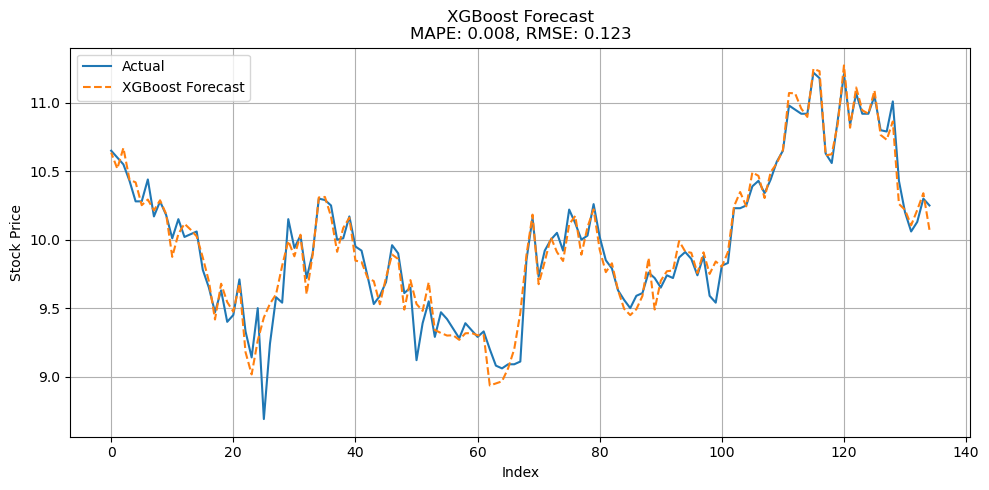

In [10]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# Create lag features
def create_lags(df, target='Price', lags=5):
    df_lag = df[['Date', target, 'Open', 'High', 'Low', 'Volume', 'Change_pct', 'DayOfWeek', 'Month', 'Quarter']].copy()
    for i in range(1, lags+1):
        df_lag[f'lag_{i}'] = df_lag[target].shift(i)
    return df_lag.dropna()

df_xgb = create_lags(df_cleaned)
X = df_xgb.drop(columns=['Date', 'Price'])
y = df_xgb['Price']

# Split
X_train, X_test = X.iloc[:-135], X.iloc[-135:]
y_train, y_test = y.iloc[:-135], y.iloc[-135:]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Metrics
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
rmse_xgb = sqrt(mean_squared_error(y_test, y_pred_xgb))

# Plot XGBoost
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred_xgb, label='XGBoost Forecast', linestyle='--')
plt.title(f'XGBoost Forecast\nMAPE: {mape_xgb:.3f}, RMSE: {rmse_xgb:.3f}')
plt.xlabel('Index')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Ahmad\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


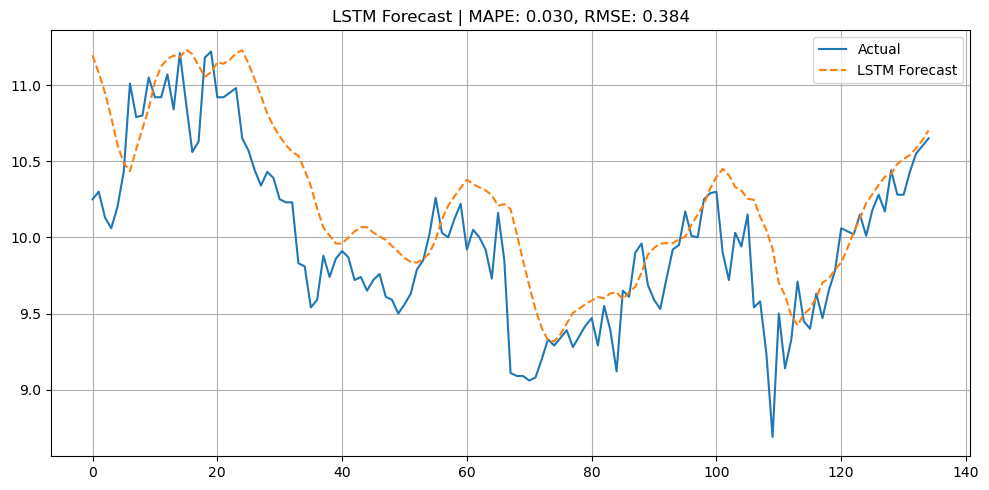

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Scale the target
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df_cleaned['Price'].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 10
X, y = create_sequences(scaled_prices, SEQ_LEN)

X_train, X_test = X[:-135], X[-135:]
y_train, y_test = y[:-135], y[-135:]

# Model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(SEQ_LEN, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=20, verbose=0)

# Predict
y_pred_scaled = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_scaled)
y_test_lstm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
mape_lstm = mean_absolute_percentage_error(y_test_lstm, y_pred_lstm)
rmse_lstm = sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test_lstm, label='Actual')
plt.plot(y_pred_lstm, label='LSTM Forecast', linestyle='--')
plt.title(f"LSTM Forecast | MAPE: {mape_lstm:.3f}, RMSE: {rmse_lstm:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()